# Arrival Time Prediction - Performance
This notebook is the final notebook on the work on GP regression for arrival time prediction, which measures the models performance. The data used is loaded from train/test pickle files which contains un-processed data. Since we assume that the synchronisation functions is constant, they are simply loaded from file.

In [18]:
import numpy as np
import pandas as pd
import gp_gpy as gp

def rename(d):
    return d.rename(columns = {
        'latitude': 'lat', 
        'longitude': 'lon', 
        'journey_number': 'traj', 
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    
version = 3
LIKELIHOOD_MODEL = 'likelihood-' + str(version)
PREDICTION_MODEL = 'predict-' + str(version)  
train = rename(pd.read_pickle('./benchmark_train.pkl')).sort_values(['traj', 'seg', 'timestamp'])
test = rename(pd.read_pickle('./benchmark_test.pkl')).sort_values(['traj', 'seg', 'timestamp'])
train.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,lon,lat,direction,speed,station,traj,seg
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


In [36]:
import time
def stop_compress(data):
    from math import radians, cos, sin, asin, sqrt, isnan
    import dateutil.parser
    
    def haversine(lon1, lat1, lon2, lat2):
        """
       Calculate the great circle distance between two points
       on the earth (specified in decimal degrees)
       """
        # convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371 # Radius of earth in kilometers
        
        return c * r
 
    def as_dict(d, compressed):
        return {
            'lat': d.lat,
            'lon': d.lon,
            'seg': d.seg,
            'speed': d.speed,
            'traj': int(d.traj),
            'timestamp': d.timestamp,
            'event': d.event,
            'compressed': compressed
        }

    # still requires double pd.to_datetime(..)
    def mean_timestamp(timestamps):
        x = timestamps.apply(dateutil.parser.parse)
        epochs = [ t.timestamp() for t in x ]
        mean_epoch = int(np.mean(epochs))
        dt = pd.to_datetime(mean_epoch, unit = 's')    
        return dt
 
    def compress(data):
        dict_data = [as_dict(x, 0) for x in data]
        if len(dict_data) == 1: 
            return dict_data[0]
   
        df = pd.DataFrame(dict_data)   
        df.speed = np.max(df.speed, 0) # data contains -1 sentinel values for missing speed
 
        df2 = df.drop(['timestamp', 'event', 'seg'], axis=1).apply(np.mean, axis=0)
        df2['timestamp'] = mean_timestamp(df['timestamp'])
        df2['timestamp'] = pd.to_datetime(df2['timestamp'])
   
        contains_entered_event = lambda df : df.event.transform(lambda e : e == 'EnteredEvent').any()
        df2['event'] = 'EnteredEvent' if contains_entered_event(df) else 'ObservedPositionEvent'
        df2['seg'] = df.seg.min() # In the case of overlapping segments we let the data belong to the first
 
        return as_dict(df2, 1)

    delta = 4e-3 # approx. 4 metres
    output = []
    buffer = [ data.iloc[0] ]
     for current in data.itertuples():
        if current.Index == data.index[0]: 
            continue
       
        distance = haversine(current.lat, current.lon, buffer[-1].lat, buffer[-1].lon)
   
        if distance > delta:
            output.append(compress(buffer))
            buffer.clear()
   
        buffer.append(current)
    

    if len(buffer) > 0:
        output.append(compress(buffer))

    compressed_data = pd.DataFrame(output)
    return compressed_data


In [37]:
t0 = time.time()
compressed_train = stop_compress(train)
elapsed = time.time() - t0
print("Train processed in", elapsed, "seconds")


Int64Index([0, 1, 2, 3, 4], dtype='int64')
Train processed in 603.9817800521851 seconds


In [38]:
t0 = time.time()
compressed_test = stop_compress(test)
elapsed = time.time() - t0
print("Test processed in", elapsed, "seconds")

Test processed in 150.0655641555786 seconds


In [57]:

from IPython.display import display, clear_output

def compute_progress(data):
    time_left = pd.DataFrame({'time_left': np.zeros(data.shape[0])})
    progress = pd.DataFrame({'progress': np.zeros(data.shape[0])})
    reverse_rows = data.iloc[::-1]
    last_stop_timestamp = reverse_rows.iloc[0].timestamp
    trajs = data.traj.unique()
    segs = data.seg.unique()

    sdata = data.sort_values(['traj', 'seg', 'timestamp'])
    cur_traj = 0
    cur_seg = 0
    tn = 0
    seg0 = 0
    segn = 0
    traj = sdata
    for i, d in sdata.iterrows():
        if d.traj > cur_traj:
            cur_seg = 0
            cur_traj = d.traj
            traj = sdata[sdata.traj == cur_traj]

        if d.seg > cur_seg:
            cur_seg = d.seg
            seg0 = i
            seg = traj[traj.seg == cur_seg]
            segn = seg.shape[0]
            tn = seg.iloc[-1].timestamp

        time_left.iloc[i] = (tn - d.timestamp).seconds
        progress.iloc[i]  = (i - seg0) / (segn - 1)
        
        if i % 1000 == 0:
            clear_output(wait=True)
            display('processed row ' + str(i) + ' out of ' + str(sdata.shape[0]))
    
    return pd.concat([
        data[['lat', 
              'lon', 
              'traj', 
              'seg', 
              'speed']],
        time_left,
        progress],
        axis = 1)


In [56]:
t0 = time.time()
progress_train = compute_progress(compressed_train)
dt = time.time() - t0
print("Train processed in", dt, " seconds")
progress_train.to_pickle('progress_train.pkl')
progress_train.head()

'processed row1568000 out of 1568016'

Train processed in 518.6274816989899  seconds


,lat,lon,traj,seg,speed,time_left,progress
0,15.571012,58.414258,1,1,0.00,66.0,0.000000
1,15.571187,58.414196,1,1,-1.00,58.0,0.026316
2,15.571246,58.414280,1,1,3.08,47.0,0.052632
3,15.571079,58.414436,1,1,4.37,35.0,0.078947
4,15.570891,58.414459,1,1,6.73,34.0,0.105263


In [59]:
t0 = time.time()
progress_test = compute_progress(compressed_test)
dt = time.time() - t0
print("Test processed in", dt, " seconds")
progress_test.to_pickle('progress_test.pkl')
progress_test.head()

'processed row 392000 out of 392015'

Test processed in 126.75161933898926  seconds


,lat,lon,traj,seg,speed,time_left,progress
0,15.571014,58.414226,14,1,0.00,134.0,0.000000
1,15.571211,58.414173,14,1,-1.00,56.0,0.026316
2,15.571200,58.414193,14,1,3.49,51.0,0.052632
3,15.571306,58.414377,14,1,3.54,40.0,0.078947
4,15.570859,58.414452,14,1,6.68,34.0,0.105263


In [4]:
import numpy as np
import pandas as pd
import gp_gpy as gp
progress_train = pd.read_pickle('progress_test.pkl')
progress_train.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.565062,58.414597,1,2,4.62,52.0,0.000000
1,15.564899,58.414546,1,2,4.01,45.0,0.027778
2,15.564622,58.414425,1,2,-1.00,36.0,0.055556
3,15.564853,58.414530,1,2,2.93,35.0,0.083333
4,15.564763,58.414486,1,2,3.90,32.0,0.111111


In [89]:
import GPy

def synch_traj(synch_gp, data):
    X = data[['lat', 'lon']].values
    tau, _var = gp.predict(synch_gp, X)
    return data.assign(tau=tau.reshape(tau.shape[0]))

def train_seg_gps(seg, route_n, traj_n, seg_n):
    synch_gp = gp.load_synch(route_n, seg_n, version=version)
    synched_seg = synch_traj(synch_gp, seg)
    n_restarts = 5
    print('training', route_n, traj_n, seg_n)
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg[['tau']],
        synched_seg[['lat', 'lon']],
        LIKELIHOOD_MODEL,
        route_n,
        traj_n,
        seg_n)
    #likelihood_model.model.kern.lengthscale = 0.05
    #likelihood_model.model.kern.variance = 5
    likelihood_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.2))
    likelihood_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(2, 1))
    likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.005))
    #likelihood_model.model.likelihood.variance = 0.005
    #likelihood_model.model.likelihood.variance.fix()
    
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.00005))
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg[['tau']], 
        synched_seg[['time_left']], 
        PREDICTION_MODEL, 
        route_n, 
        traj_n, 
        seg_n)    
    prediction_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.2))
    prediction_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(2, 1))
    prediction_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.005))
    #prediction_model.model.likelihood.variance = 0.005
    #prediction_model.model.likelihood.variance.fix()
    
    # the variances are too different to capture with a good prior
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.00005))
    gp.train(prediction_model, n_restarts)
    
    return likelihood_model, prediction_model

In [93]:
def train_gps(data, route_n):
    n_trajs = data.traj.unique()
    trajs = dict(tuple(data.groupby('traj')))
    for i, traj_n in enumerate(n_trajs):
        traj = trajs[traj_n] 
        n_segs = traj.seg.unique()
        segs = dict(tuple(traj.groupby('seg')))
        for seg_n in n_segs:
            seg = segs[seg_n]
            lik_model, pred_model = train_seg_gps(seg, route_n, traj_n, seg_n)
            gp.save(lik_model)
            gp.save(pred_model)

        clear_output(wait=True)
        display('Trained ' + str(i) + ' out of ' + str(len(n_trajs)) + ' trajectories')

        #name = LIKELIHOOD_MODEL + str(route_n) + '-' + str(traj_n) + '-' + str(seg_n)
        #lik_model.model.save_model(name, compress=False)
        #loaded_model = GPy.load(name)
        #print(lik_model.model)
        #print(gp.load(LIKELIHOOD_MODEL, route_n, traj_n, seg_n).model) 
        #print(pred_model.model)

In [94]:
%%capture
t0 = time.time()
route_n = 3

progress_train = progress_train[progress_train.seg > 1]
train_gps(progress_train, route_n)
dt = time.time() - t0
print("Train processed in", dt, " seconds")

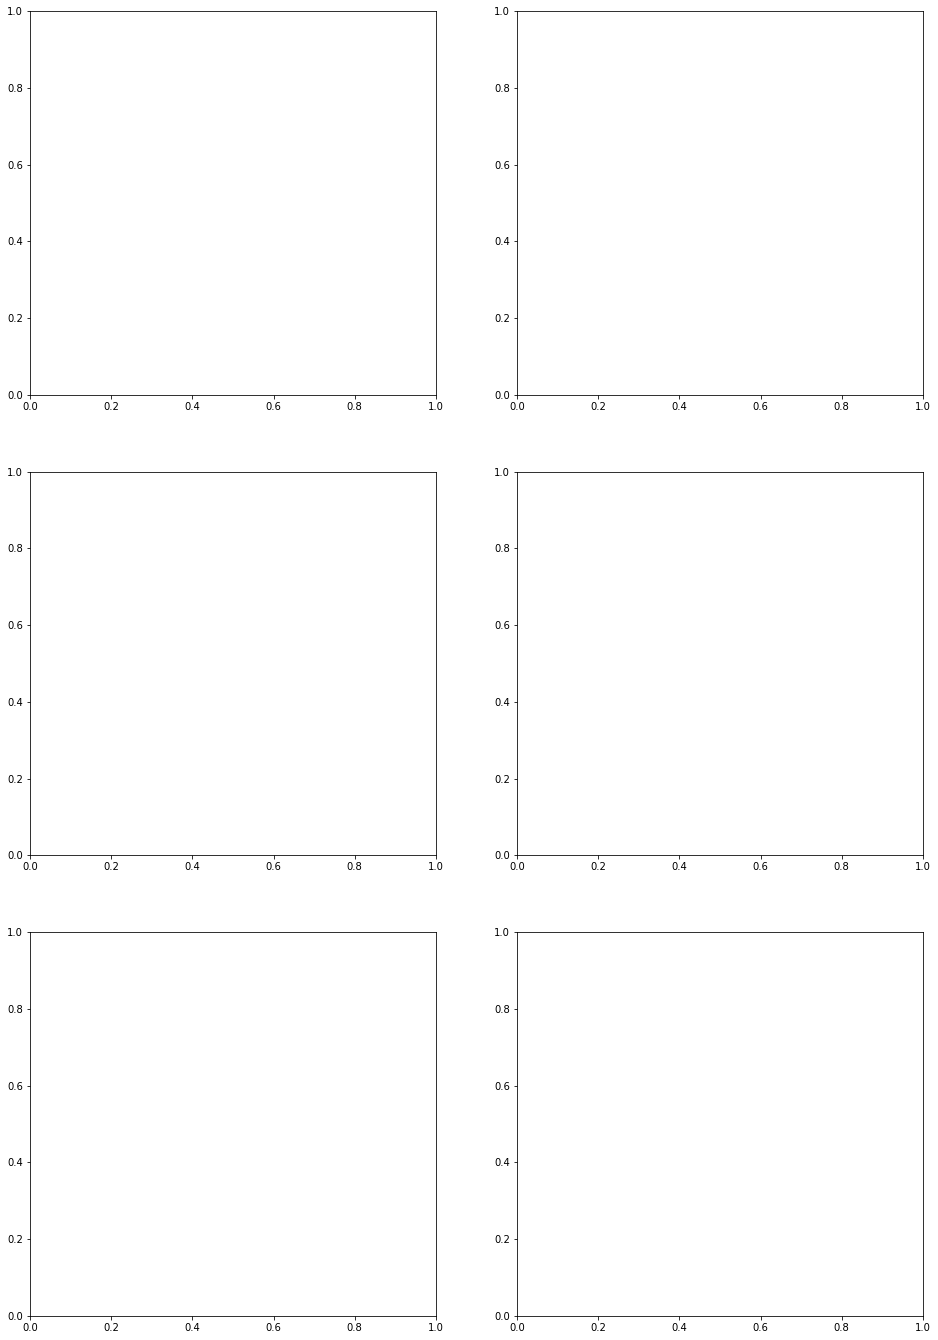

In [99]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

def plot_likelihood_models(models_by_loglik, synched_traj):
    
    def to_df(m, i):
        df = pd.DataFrame(gp.predict(m, X)[0], columns=['lat' ,'lon'])
        df['Similarity rank'] = i
        return df
    
 
    #print([(m[0].route_n, m[0].traj_n, m[0].seg_n) for m in models_by_loglik[:n_models_to_plot]])
    X = synched_traj[['tau']].values
    n_models_to_plot = 10
    models_to_plot = models_by_loglik[:n_models_to_plot]
    n_models = len(models_to_plot)
    dfs = [to_df(mloglik[0], i) for mloglik, i in zip(models_to_plot, range(n_models))]
    traj_df = synched_traj.copy()
    traj_df['Similarity rank'] = 0
    plt_df = pd.concat([traj_df] + dfs)
    
    sns.scatterplot(data=plt_df, x='lat', y='lon', hue='Similarity rank', ax=axs[0, 1])
    axs[0, 1].set_title('New trajectory with the most similair known trajectories')
    axs[0, 1].set_aspect('equal', 'datalim')    
    center_axs(axs[0, 1], synched_traj, ['lat', 'lon'])

    
def center_axs(ax, data, XY):
    ax.set_xlim(data[XY[0]].min()*0.99999, data[XY[0]].max()*1.00001)
    ax.set_ylim(data[XY[1]].min()*0.99999, data[XY[1]].max()*1.00001)
    
def mogp(traj, synch_gp, route_n, seg_n, plot):
    
    def data_loglik(model, X, Y):
        def loglik(x, y):
            mu, sigma = gp.predict(model, x.reshape(1, 1))
            return -0.5*(y-mu)*np.linalg.inv(sigma)*(y-mu).T \
                    -0.5*np.log(np.abs(sigma))
        return np.sum([loglik(x, y) for x, y in zip(X, Y)])
        
    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(data.shape[0], 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(PREDICTION_MODEL, lik_model.route_n, lik_model.traj_n, lik_model.seg_n)
        
    def weighted_models(synched_traj, models):
        """
        Returns models and their weights, weighted by the posterior predictive probability of the model
        normalised over the maximum likelihood assuming uniform model prior. 
        So the most probable model has weight w = 1.0, and the less likely models has weights 0 < w < 1.0.
        """
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        models_with_loglik = [(m, data_loglik(m, X, Y)) for m in models]
        models_by_loglik = sorted(models_with_loglik, key=lambda mw: mw[1], reverse=True)
        max_loglik = models_by_loglik[0][1]
        
        if plot:
            plot_likelihood_models(models_by_loglik, synched_traj)
            
        return [(m, np.exp(loglik - max_loglik)) for m, loglik in models_by_loglik]
    
    synched_traj = synch_traj(synch_gp, traj)
    lik_models = gp.load_trajs(LIKELIHOOD_MODEL, route_n, seg_n)
    lik_models_with_weights = weighted_models(synched_traj, lik_models)
    pred_models_with_weights = [(corresponding_pred_model(lik_m), w) for lik_m, w in lik_models_with_weights]
    #print('Most similair model', lik_models_with_weights[0][0].route_n, lik_models_with_weights[0][0].traj_n, lik_models_with_weights[0][0].seg_n)
    
    if plot:
        pred_models_with_weights[0][0].model.plot(ax=axs[2, 1])
        axs[2, 1].set_title('Most similair prediction GP')
        
    latest_tau = synched_traj.iloc[-1][['tau']].values.reshape(1, 1)
    mean_var_weights = [gp.predict(m, latest_tau) + (w,) for m, w in pred_models_with_weights]
    return mean_var_weights

def predict(traj, synch_gp, route_n, seg_n, arrival_time=None, plot=False):
    mean_var_weights = mogp(traj, synch_gp, route_n, seg_n, plot)
    mean_var_weights = mean_var_weights #[:10] 
    if plot:
        sort = sorted(mean_var_weights, key=lambda mvw: mvw[0])
        xmin = max(0, np.floor(float(sort[0][0]-sort[0][1]*3)))
        xmax = np.ceil(float(sort[-1][0]+sort[-1][1]*3))
        x = np.linspace(xmin, xmax, 200)
        
        if plot:
            for mean, var, w in mean_var_weights:
                axs[1,0].plot(x, w*norm.pdf(x, float(mean), np.sqrt(float(var))))

            axs[1,0].set_title('Mixture of predictions')
            axs[1,0].set_xlabel('Seconds')
            axs[1,0].set_ylabel('Density')
            if arrival_time:
                axs[1,0].axvline(x=arrival_time, label='True arrival time')
                axs[1,0].legend()

    #models_by_similarity = sorted(mean_var_weights, key=lambda p: p[2], reverse=True)
    #models_by_mode = sorted(mean_var_weights, key=lambda p: p[0]*p[2], reverse=True)
    total_weight = sum([w for _, _, w in mean_var_weights])
    weighted_mean = sum([w*float(mean) for mean, var, w in mean_var_weights])/total_weight
    
    #weighted_means = [w*float(mean) for mean, var, w in mean_var_weights]
    #print(weighted_means)
    #mode_model = models_by_mode[0] #mean_var_weights[np.argmax(weighted_means)]
    
    #print(mode_model)
    #n = 200
    #distribution = np.sum([norm.pdf(n, float(mean), np.sqrt(float(var))) for mean, var, w in mean_var_weights])
   
    #print(weighted_means)
    #print(mode_model)
    return weighted_mean #float(mode_model[0])

#np.random.seed(8)
plot = True
if plot:
    fig, axs = plt.subplots(3,2)
    fig.set_figwidth(16)
    fig.set_figheight(24)
    
test = train #pd.read_pickle('test.pkl')
n_test_trajs_to_use = 38
n_test_trajs = test.traj.unique()
test = test[test.traj < n_test_trajs[n_test_trajs_to_use]]
traj_n = n_test_trajs[0]
test_traj = test[test.traj == traj_n]
seg_ix = 3
seg_n = test_traj.seg.unique()[seg_ix]
test_seg = test_traj[test_traj.seg == seg_n]
def predict_seg_with_plots(seg, route_n, seg_n, true_pred_gp=None):
    i = test_seg.index[0]+5 #np.random.randint(test_seg.index[0], test_seg.index[-1])
    seg = seg[seg.index <= i]
    synch_gp = gp.load_synch(route_n, seg_n, version=version)
    true = seg.iloc[-1].time_left
    pred = predict(seg, synch_gp, route_n, seg_n, true, plot=True)
    mae = float(np.abs(true-pred))
    mape = float(np.abs((true-pred)/true))
    print('true model', route_n, traj_n, seg_n)
    print('pred:', f"{pred:.2f}", 'true:', float(true), 'MAE:', f"{mae:.2f}", 'MAPE:', f"{mape:.2f}")
    
    sns.scatterplot(data=seg, x='lat', y='lon', ax=axs[0, 0])
    axs[0, 0].set_title('The new trajectory')
    axs[0, 0].set_aspect('equal', 'datalim')
    center_axs(axs[0, 0], seg, ['lat', 'lon'])
    
    synch_gp.model.plot(ax=axs[1,1])
    axs[1,1].set_title('Synchronisation GP for the new trajectory segment')
    if true_pred_gp:
        true_pred_gp.model.plot(ax=axs[2, 0])
        axs[2,0].set_title('The true prediction GP')
    
#print(test_seg[['lat', 'lon']])
#pred_gp = gp.load(PREDICTION_MODEL, route_n, traj_n, seg_n)
#predict_seg_with_plots(test_seg, route_n, seg_n, true_pred_gp=pred_gp)


In [ ]:
from collections import defaultdict
test = pd.read_pickle('progress_test.pkl')
seg_sizes = [.2, .4, .6, .8]
n_segs = test.seg.unique()
segs = dict(tuple(test.groupby('seg')))
mape = {s: defaultdict(dict) for s in seg_sizes}
mae =  {s: defaultdict(dict) for s in seg_sizes}
for seg_n in n_segs[1:50]:
    seg = segs[seg_n]
    n_trajs = seg.traj.unique()
    trajs = dict(tuple(seg.groupby('traj')))
    for i, traj_n in enumerate(n_trajs):
        traj = trajs[traj_n]
        for size in seg_sizes:
            n = round(traj.shape[0]*size)
            traj_start = traj[:n]
            synch_gp = gp.load_synch(route_n, seg_n, version=version)
            X = traj_start[['lat', 'lon']]
            y = traj_start.iloc[-1].time_left
            pred = predict(X, synch_gp, route_n, int(seg_n), y, plot=False)
            mae[size][seg_n][traj_n]  = float(np.abs(y-pred))
            mape[size][seg_n][traj_n] = float(np.abs((y-pred)/y))
    
        clear_output(wait=True)
        display('Evaluated ' + str(i) + ' out of ' + str(len(n_trajs)) + ' trajs')
display('done')

'Evaluated 39 out of 720 trajs'

In [ ]:
for seg_n in n_test_segs:
    seg = test[test.seg == seg_n]
    synch_gp = gp.load_synch(route_n, seg_n, version=version)
    for traj_n in seg.traj.unique():
        traj = seg[seg.traj == traj_n]
        i = np.random.randint(traj.index[0], traj.index[-1])
        traj = traj[traj.index <= i]
        true = traj.iloc[-1].time_left
        pred = predict(traj, synch_gp, route_n, int(seg_n), true, plot=False)
        mae.append(float(np.abs(true-pred)))
        mape.append(float(np.abs((true-pred)/true)))

    clear_output(wait=True)
    display('Evaluated ' + str(i) + ' out of ' + str(len(n_trajs)) + ' trajectories')
